# **S&P 500 Index Forecasting**

In [133]:
!pip install tensorflow

In [227]:
import yfinance as yf
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout

In [2]:
import warnings
warnings.filterwarnings("ignore")

## **Part 1: Statistical Method - Time Series Analysis**
Build an ARIMA model for forecasting.

### **Step 1: Data Pre-processing**

In [103]:
# Download S&P 500 index daily data (ticker: ^GSPC)
sp500 = yf.download('^GSPC',
                    start='2000-01-01',
                    end='2025-04-01', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [104]:
sp500 = sp500[['Close']].dropna()

In [105]:
sp500

Price,Close
Ticker,^GSPC
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971
...,...
2025-03-25,5776.649902
2025-03-26,5712.200195


In [164]:
# use data from 2000 to 2020-03-31 for training
sp500_train = sp500.loc[:'2020-04-01']
# use data starting from 2020-04-01 for testing
sp500_test = sp500.loc['2020-04-01':]

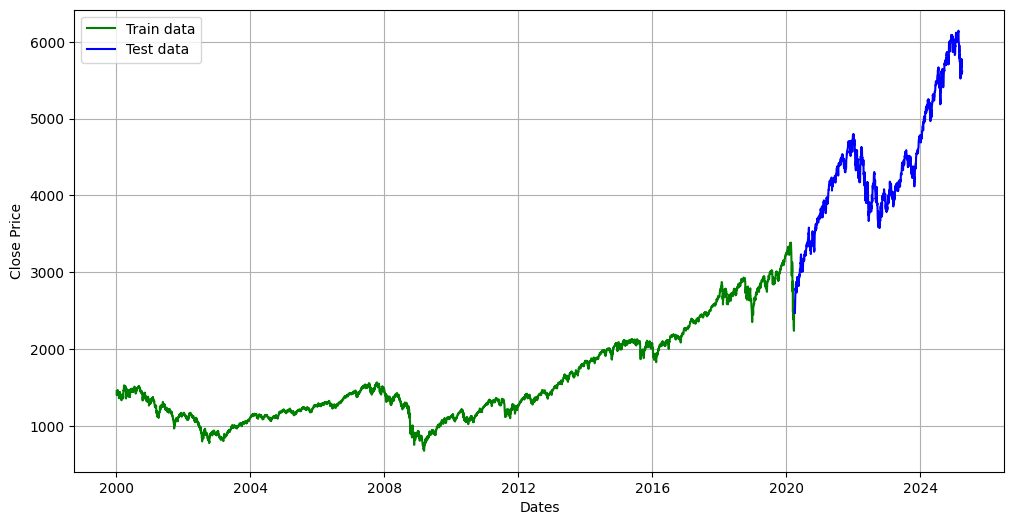

In [165]:
plt.figure(figsize=(12,6))
plt.xlabel('Dates')
plt.ylabel('Close Price')
plt.plot(sp500_train, 'green', label='Train data')
plt.plot(sp500_test, 'blue', label='Test data')
plt.grid(True)
plt.legend()



- **Stationarity:** A stationarity in a time series means that its mean and variance do not change over time.

- ARIMA works better on stationary series. Daily stock data is often too noisy. Resample to **Monthly Average**.




In [166]:
# Resample to monthly average
sp500_train_monthly = sp500_train['Close'].resample('M').mean()

In [167]:
sp500_train_monthly.head(5)

Ticker,^GSPC
Date,
2000-01-31,1425.585504
2000-02-29,1388.874500
2000-03-31,1442.212599
2000-04-30,1461.355257
2000-05-31,1418.479548


**Check for Stationarity (ADF Test):**
- p-value is greater than 0.05, series is not stationary


In [168]:
result = adfuller(sp500_train_monthly)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -0.3967870430109548
p-value: 0.9106338455707976


Take **first difference** to make the series stationary.

Now p-value is less than 0.05, the series is stationary.

In [169]:
sp500_diff = sp500_train_monthly.diff().dropna()

In [170]:
result = adfuller(sp500_diff)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.90954905065818
p-value: 0.04424878796287707


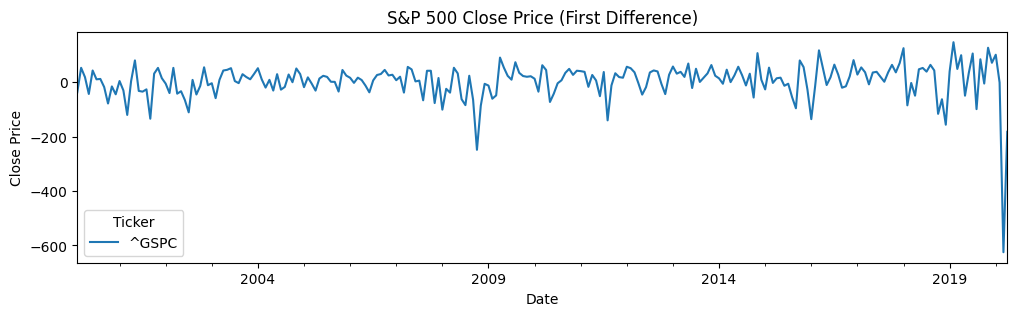

In [171]:
sp500_diff.plot(figsize=(12, 3), title='S&P 500 Close Price (First Difference)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

### **Step 2: Fit ARIMA Model**
Choose **ARIMA Order (p, d, q)**
- Use first difference: d = 1
- Grid Search p and q: Look for model with the lowest AIC

In [177]:
best_aic = np.inf
best_order = None

for p in range(0, 8):
  for q in range(0, 8):
    model = ARIMA(sp500_train_monthly, order=(p,1,q))
    results = model.fit()
    if results.aic < best_aic:
      best_aic = results.aic
      best_order = (p,1,q)

In [178]:
print(f'Best AIC: {best_aic}, Order: {best_order}')

Best AIC: 2705.8656603393288, Order: (4, 1, 5)


**Best model: ARIMA(4, 1, 5)**

Perform model diagnostics.

In [179]:
best_model = ARIMA(sp500_train_monthly, order=(4, 1, 5))
best_model_fit = best_model.fit()
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  ^GSPC   No. Observations:                  244
Model:                 ARIMA(4, 1, 5)   Log Likelihood               -1342.933
Date:                Mon, 14 Apr 2025   AIC                           2705.866
Time:                        23:25:21   BIC                           2740.796
Sample:                    01-31-2000   HQIC                          2719.935
                         - 04-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1549      0.088     -1.767      0.077      -0.327       0.017
ar.L2          0.3580      0.092      3.877      0.000       0.177       0.539
ar.L3         -0.1725      0.068     -2.524      0.0

- Top left: The residual errors appear to have a uniform variance and fluctuate
around a mean of zero.
- Top Right: normal distribution with a mean of around zero.
- Bottom left: Normal Distribution
- Bottom Right: The residual errors are not autocorrelated

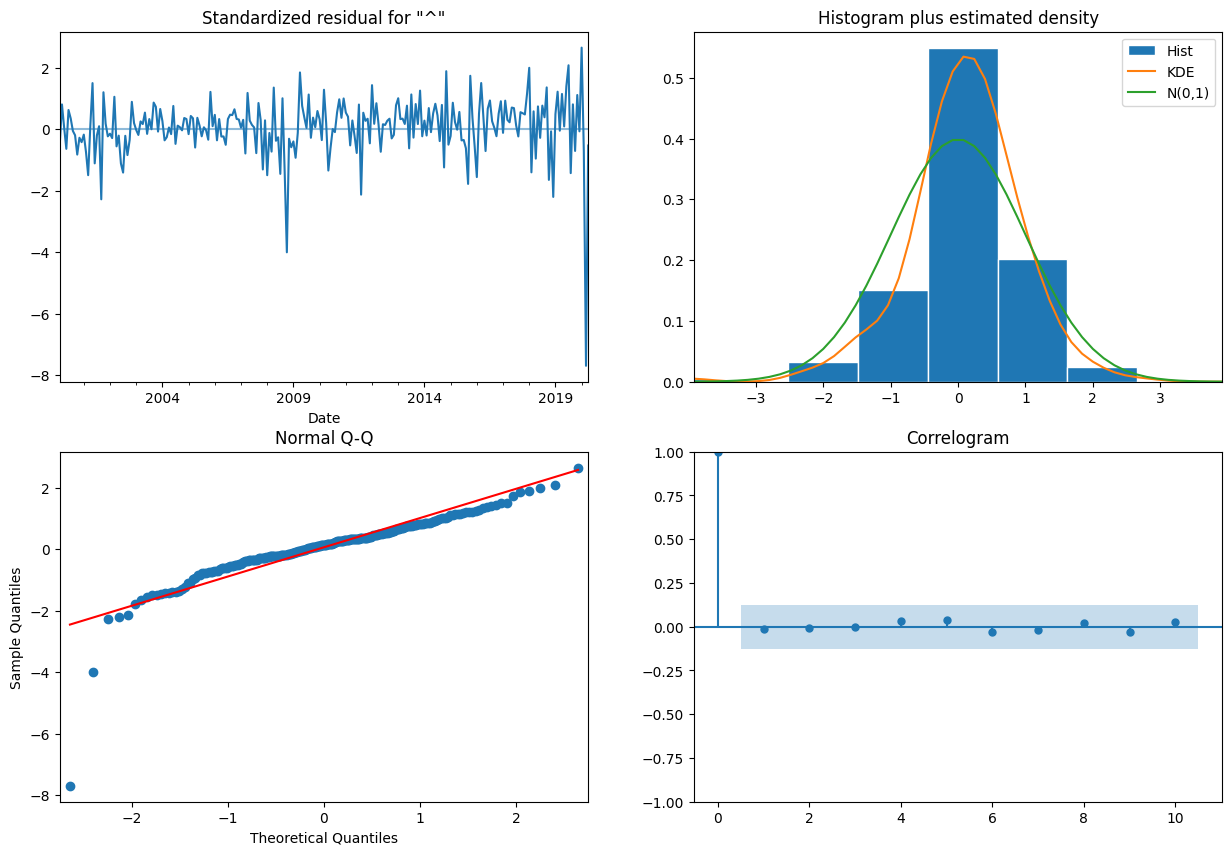

In [246]:
best_model_fit.plot_diagnostics(figsize=(15,10))
plt.show()

### **Step 3: Forecasting**
**Final model: ARIMA(4, 1, 5)**

In [181]:
sp500_test_monthly = sp500_test['Close'].resample('M').mean()
sp500_test_monthly.shape

(60, 1)

In [182]:
history = list(sp500_train_monthly.values)
predictions = []
lower_bounds = []
upper_bounds = []

In [183]:
# Rolling Forecast with 95% Confidence Interval
for t in range(len(sp500_test_monthly)):

    model = ARIMA(history, order=(4, 1, 5))
    model_fit = model.fit()

    forecast_obj = model_fit.get_forecast(steps=1)
    forecast = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int(alpha=0.05)

    predictions.append(forecast[0])
    lower_bounds.append(conf_int[0, 0])
    upper_bounds.append(conf_int[0, 1])

    history.append(sp500_test_monthly.values[t])

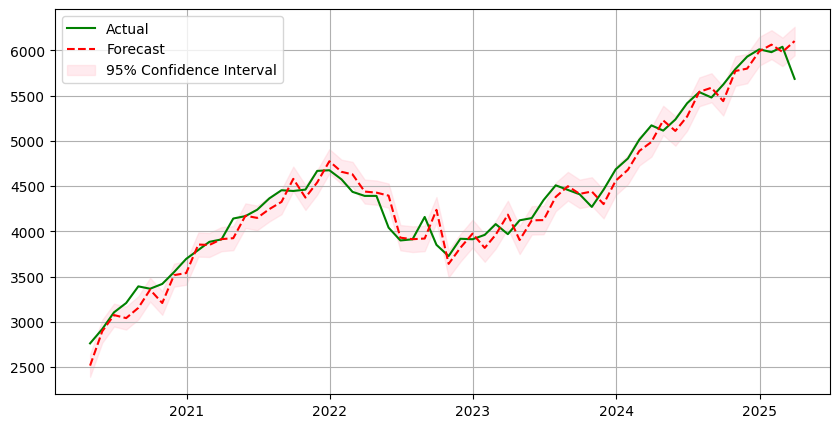

In [247]:
test_index = sp500_test_monthly.index
plt.figure(figsize=(10,5))
plt.plot(test_index, sp500_test_monthly.values, label="Actual", color="green")
plt.plot(test_index, predictions, label="Forecast", color="red", linestyle="dashed")
plt.fill_between(test_index, lower_bounds, upper_bounds, color="pink",
                 alpha=0.3, label="95% Confidence Interval")
plt.grid(True)
plt.legend()
plt.show()

In [186]:
mae = mean_absolute_error(sp500_test_monthly.values, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

rmse = np.sqrt(mean_squared_error(sp500_test_monthly.values, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 120.88321336708044
Root Mean Squared Error (RMSE): 152.1622256425368


## **Part 2: Deep Learning - Recurrent Neural Networks**
Develop a Recurrent Neural Network (RNN) model using Long Short-Term Memory (LSTM) architecture for sequence prediction tasks.

In [208]:
# use daily data
sp500.shape

(6349, 1)

### **Step 1: Data Pre-processing**

Normalize the Data.

In [209]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sp500)

Create sequences for LSTM.

use 60 previous days(2 months of daily data) to predict the next day's value.

In [210]:
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_sequences(scaled_data, time_steps)

Train test split.

In [211]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [212]:
# Reshape for LSTM Input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### **Step 2: Build RNN model**

- Two stacked LSTM layers

- Dropout to reduce overfitting

- Predict next day's index value

In [236]:
def build_and_train_rnn(X_train, y_train, X_val, y_val,
                        lstm_units, dropout_rate,
                         optimizer, epochs, batch_size,
                         plot_learning=True):

    model = Sequential()
    model.add(LSTM(units=lstm_units,
                   return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        verbose=1)

    # Plot learning curves
    if plot_learning:
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('LSTM Learning Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    return model, history

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 54s 114ms/step - loss: 0.0043 - val_loss: 0.0079
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - loss: 7.9579e-04 - val_loss: 0.0023
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - loss: 5.0272e-04 - val_loss: 0.0017
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - loss: 3.9133e-04 - val_loss: 0.0039
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - loss: 4.0671e-04 - val_loss: 0.0057
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - loss: 3.4045e-04 - val_loss: 8.2747e-04
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - loss: 2.7434e-04 - val_loss: 0.0029
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - loss: 2.6822e-04 - val_loss: 9.6627e-04
Epoch 9/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - loss: 3.3081e-04 - val_loss: 4.3944e-04
Epoch 10/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - loss: 2.7443e-04 - val_loss: 3.3102e-04


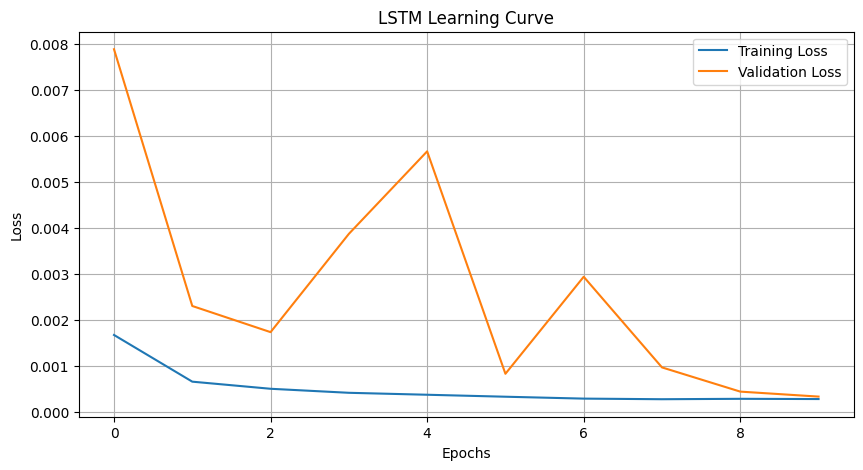

In [237]:
model, history = build_and_train_rnn(
    X_train=X_train,
    y_train=y_train,
    X_val=X_test,
    y_val=y_test,
    lstm_units=64,
    dropout_rate=0.4,
    optimizer='adam',
    epochs=10,
    batch_size=32,
    plot_learning=True
)

In [238]:
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_31 (LSTM)                  │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,957 (585.77 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,972 (390.52 KB)

In [242]:
# Predict and inverse transform
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
MAE: 75.97
RMSE: 99.48


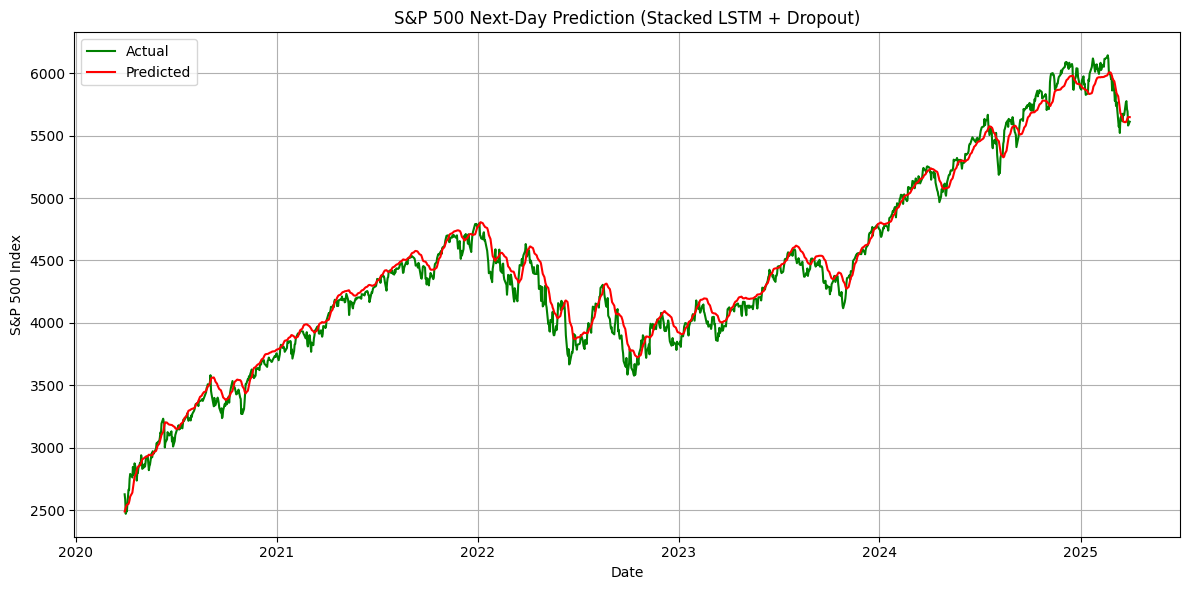

In [243]:
test_dates = sp500.index[-len(y_test):]
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, label='Actual', color="green")
plt.plot(test_dates, y_pred, label='Predicted', color="red")
plt.xlabel('Date')
plt.ylabel('S&P 500 Index')
plt.title('S&P 500 Next-Day Prediction (Stacked LSTM + Dropout)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()